In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import linear, relu, sigmoid


from keras.datasets import mnist



2024-06-16 15:31:19.198277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/damanr/Desktop/myprojectA/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [27]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [28]:
print(f'The shape of the training example features (X_train): {X_train.shape}')
print(f'The shape of the training example labels   (y_train): {y_train.shape}', end = '\n\n')

print(f'The shape of the test example features (X_test): {X_test.shape}')
print(f'The shape of the test example labels   (y_test): {y_test.shape}')



The shape of the training example features (X_train): (60000, 28, 28)
The shape of the training example labels   (y_train): (60000,)

The shape of the test example features (X_test): (10000, 28, 28)
The shape of the test example labels   (y_test): (10000,)


In [29]:
# Create a cross validation set from the training data to assist in model architecture selection and hyperparameter tuning
cross_validation_size = 10000

X_cv, y_cv = X_train[len(X_train) - cross_validation_size:] , y_train[len(y_train) - cross_validation_size:]
X_train , y_train = X_train[:len(X_train) - cross_validation_size] , y_train[:len(y_train) - cross_validation_size]

print(f'The shape of the validation set features (X_cv): {X_cv.shape}')
print(f'The shape of the validation set labels   (y_cv): {y_cv.shape}', end = '\n\n')

print(f'New shape of the training example features (X_train): {X_train.shape}')
print(f'New shape of the training example labels   (y_train): {y_train.shape}', end = '\n\n')



The shape of the validation set features (X_cv): (10000, 28, 28)
The shape of the validation set labels   (y_cv): (10000,)

New shape of the training example features (X_train): (50000, 28, 28)
New shape of the training example labels   (y_train): (50000,)



In [30]:
#Visualize data structure
print('First 3 Training Examples',X_train[:3],sep = '\n',end = '\n\n\n')
print('Target Labels',y_train[:3],sep = '\n')

First 3 Training Examples
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


Target Labels
[5 0 4]


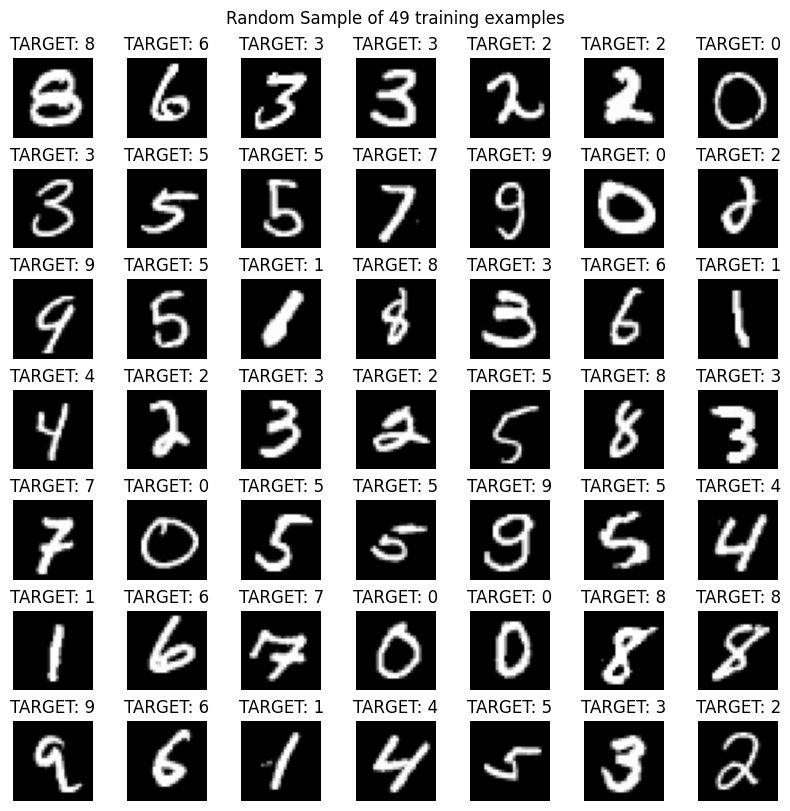

In [31]:
# View a random sampling of data
rows = 7
columns = 7 


random_indices = np.random.choice(a = len(X_train) , size = rows * columns, replace = False)

fig, axes = plt.subplots(rows,columns, constrained_layout = True)

fig.set_size_inches(8,8,forward = True)
fig.set_dpi(100)


train_count = 0
for i in range(7):
    for j in range(7):
        axes[i,j].imshow(X_train[random_indices[train_count]], cmap = 'gray')
        axes[i,j].set_title(f'TARGET: {y_train[random_indices[train_count]]}')
        axes[i,j].axis('off')
        train_count+=1

fig.suptitle(f'Random Sample of {rows * columns} training examples')

plt.show()
        

In [32]:
# Convert 28 x 28 grids of pixes to 1-D array holding sequential pixel intensities
X_train = X_train.reshape(-1,X_train.shape[1] * X_train.shape[2])
X_cv = X_cv.reshape(-1,X_cv.shape[1] * X_cv.shape[2])

X_test = X_test.reshape(-1,X_test.shape[1] * X_test.shape[2])

print(f'Finalized model input feature shape for X_train: {X_train.shape}')
print(f'Finalized model input feature shape for X_cv: {X_cv.shape}')
print(f'Finalized model input feature shape for X_test: {X_test.shape}')

Finalized model input feature shape for X_train: (50000, 784)
Finalized model input feature shape for X_cv: (10000, 784)
Finalized model input feature shape for X_test: (10000, 784)


## Creating Baseline Model 
It may be interesting to create a weak learner model that is essentially logistic regression. 
I will achieve this by creating a basic neural network with NO hidden layers, performing a classic logistic regression problem. 
This will act as a baseline to improve from. 

Performance metrics that will be analyzed:
1. Cost Function (Error Misclassified)
2. F_1 Score
   

In [33]:
baseline_model = Sequential([
    tf.keras.Input(shape = (X_train.shape[1])),
    Dense(units = 10, activation = 'linear', name = 'baseline_output')
], name = 'baseline_model')

In [34]:
baseline_model.summary()

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 baseline_output (Dense)     (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
baseline_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
)

epoch_progress = baseline_model.fit(X_train, y_train, epochs = 150)

Epoch 1/150
1563/1563 [==============================] - 2s 927us/step - loss: 28.0391
Epoch 2/150
1563/1563 [==============================] - 1s 954us/step - loss: 8.3227
Epoch 3/150
1563/1563 [==============================] - 1s 846us/step - loss: 6.1593
Epoch 4/150
1563/1563 [==============================] - 1s 847us/step - loss: 5.1049
Epoch 5/150
1563/1563 [==============================] - 1s 849us/step - loss: 4.4197
Epoch 6/150
1563/1563 [==============================] - 1s 855us/step - loss: 3.9583
Epoch 7/150
1563/1563 [==============================] - 2s 1ms/step - loss: 3.5806
Epoch 8/150
1563/1563 [==============================] - 1s 916us/step - loss: 3.2822
Epoch 9/150
1563/1563 [==============================] - 1s 950us/step - loss: 3.0480
Epoch 10/150
1563/1563 [==============================] - 2s 1ms/step - loss: 2.8196
Epoch 11/150
1563/1563 [==============================] - 1s 893us/step - loss: 2.6404
Epoch 12/150
1563/1563 [==============================]

In [36]:
epoch_progress

In [24]:
results = tf.nn.softmax(baseline_model.predict(X_cv))
print(np.sum(results, axis = 1 ))
preds = np.argmax(results, axis = 1)
np.c_[np.argmax(results, axis = 1).reshape(-1,1), y_cv]

313/313 [==============================] - 0s 755us/step
[1.0000001  1.0000001  0.9999999  ... 1.         0.99999994 1.        ]


array([[3, 3],
       [8, 8],
       [6, 6],
       ...,
       [5, 5],
       [6, 6],
       [8, 8]])

In [26]:
correct = 0
for prediction , target in zip(preds, y_cv):
    if prediction == target:
        correct+=1

print(f'Accuracy = {correct / y_cv.shape[0]}')
        

Accuracy = 0.8895
